<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

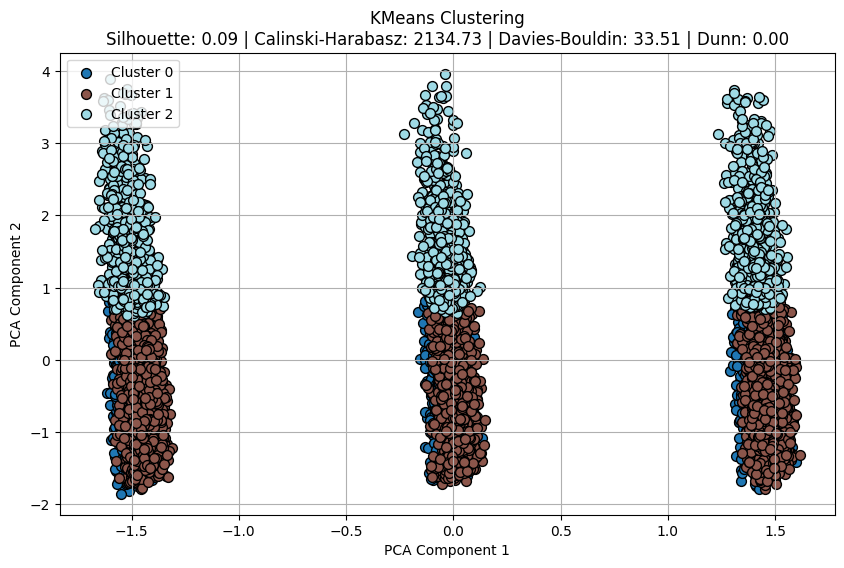

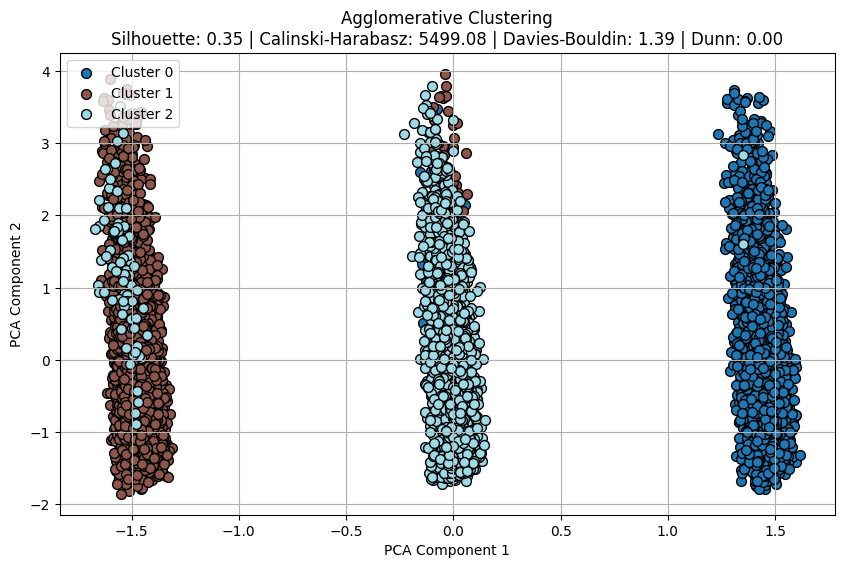

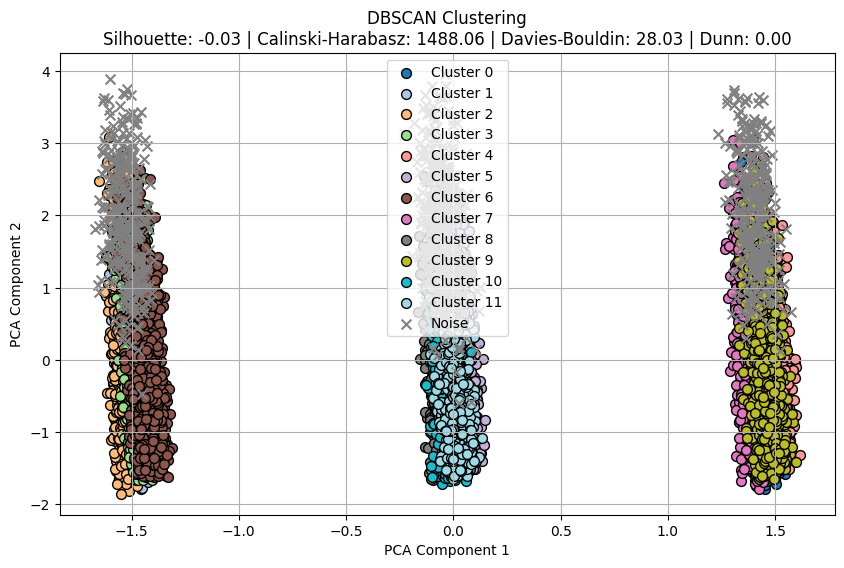

In [1]:
#------------------------------------------lab5---------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances

import warnings
warnings.filterwarnings('ignore')

# Load data from URL
url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = pd.read_csv(url)

# Select numerical features for clustering
features = [
    'debts', 'bequests', 'wife', 'husband',
    'sons', 'daughters', 'father', 'mother',
    'brothers', 'sisters'
]

X = df[features].copy()
X.fillna(X.median(), inplace=True)

# Scale features to have mean=0 and std=1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)

# Evaluate clustering metrics
def evaluate_clustering(X, labels):
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or (unique_labels == {-1}):
        return None, None, None
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

# Calculate Dunn index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) <= 1 or (set(unique_clusters) == {-1}):
        return None

    distances = pairwise_distances(X)
    intra_dists = []
    inter_dists = []

    for c in unique_clusters:
        if c == -1:
            continue
        indices = np.where(labels == c)[0]
        if len(indices) > 1:
            intra_dists.append(np.max(distances[np.ix_(indices, indices)]))

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            if -1 in (unique_clusters[i], unique_clusters[j]):
                continue
            i_idx = np.where(labels == unique_clusters[i])[0]
            j_idx = np.where(labels == unique_clusters[j])[0]
            inter_dists.append(np.min(distances[np.ix_(i_idx, j_idx)]))

    if intra_dists and inter_dists:
        return min(inter_dists) / max(intra_dists)
    else:
        return None

# Plot clusters on 2D PCA components
def plot_clusters(pca_data, labels, title):
    unique_labels = set(labels) - {-1}
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(10, 6))
    for k, col in zip(unique_labels, colors):
        mask = (labels == k)
        plt.scatter(
            pca_data[mask, 0], pca_data[mask, 1],
            c=[col],
            label=f'Cluster {k}',
            s=50, edgecolor='k'
        )

    noise_mask = (labels == -1)
    if np.any(noise_mask):
        plt.scatter(
            pca_data[noise_mask, 0], pca_data[noise_mask, 1],
            c='grey', label='Noise', s=50, edgecolor='k', marker='x'
        )

    sil, ch, db = evaluate_clustering(pca_data, labels)
    dunn = dunn_index(pca_data, labels)
    if sil is not None:
        metrics = f"Silhouette: {sil:.2f} | Calinski-Harabasz: {ch:.2f} | Davies-Bouldin: {db:.2f} | Dunn: {dunn:.2f}"
    else:
        metrics = "Недостаточно кластеров для оценки"
    plt.title(f"{title}\n{metrics}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(scaled_data)
plot_clusters(pca_data, labels_kmeans, "KMeans Clustering")

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(scaled_data)
plot_clusters(pca_data, labels_agglo, "Agglomerative Clustering")

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(scaled_data)
plot_clusters(pca_data, labels_dbscan, "DBSCAN Clustering")
